## import

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import*
except:
  print('Error Initialising Iminuit')

In [2]:
try:
  from Minuit_newClass import ExtendedMinuit
except:
  print("error initialising Extended Minuit")

In [3]:
from IPython.display import Latex
import sympy as sp

In [4]:
from random import random
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axis import Axis

## funcs

In [5]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [6]:
def grafico(x,y,xerr,yerr, title, xlabel='x', ylabel='y', save=False):

  fig,ax = plt.subplots(1,1)

  ax.scatter(x,y, c='k')
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)
  # ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if save:  plt.savefig(title+'.pdf')
  return ax

In [7]:
def visualize_minuit(my_minuit,xlabel='x',ylabel='y',xerr=0 ,yerr=0, labels='data'):

  data = my_minuit.visualize
  # plt.close()
  # fig,ax = plt.subplots(1,1)

  # ax.scatter(data[0][0],data[0][1], c='k')
  # ax.errorbar(data[0][0],data[0][1],xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)

  # ax.plot(data[1][0],data[1][1], c='r')
  # ax.set_xlabel(xlabel)
  # ax.set_ylabel(ylabel)
  # ax.legend(labels)

  return data

In [8]:
#@title Test ipotesi
def draw_p_value(fval, ndof, x_limit = 40):
  '''draws pvalue
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)}'])
  plt.plot(x,y)

def t_value(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [9]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [10]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

In [11]:
def sn(t,dec=1):
    return ("{:."+f"{dec}"+"e}").format(t)

# Data

In [12]:
data = 'https://docs.google.com/spreadsheets/d/1opp5UuS4x_MxOkC9whXrOPMLZohAEA4LmKT7oxHks8M/export?format=xlsx'

In [13]:
df = pd.read_excel(data,sheet_name=None)
print(df.keys())

dict_keys(['FP 1', 'FP 2', 'M 1', 'M 2', 'M 4', 'Righello'])


# Fabry Perot 1

In [14]:
fp1 = df['FP 1']
angolo = fp1['angolo'].to_numpy()
N_fp1 = fp1['N cerchio'].to_numpy()
cs_angolo = np.cos(angolo)

In [15]:
g = grafico(angolo,N_fp1,0.001,1,'Dati',save=True)
plt.close()

In [16]:
l_laser = 633*1e-9
def f1(x,a,d):
  return (x*l_laser)/(2*d) + a*(l_laser/(4*np.pi*d))

In [17]:
raggi = fp1['raggio cerchio']
dist = fp1['distanza da fuoco']

In [18]:
formula = 'atan(dy/dx)'
err = formula_errori('dy,dx',formula,True)
Latex(r'$\sigma_\theta$ ='+err)

<IPython.core.display.Latex object>

In [19]:
#@title errore angoli
def errore_angoli(dx,dy, errx=1e-1, erry=1e-1):
  formula = 'atan(dy/dx)'
  err = formula_errori('dy,dx',formula,False)

  err_ang = []

  dy=np.array(dy)
  if 1 == dy.size:
    values = {'dy':dy,
              'dx':dx
              }
    errors = {'dy':erry,
              'dx':errx
              }

    return valuta_errori(err, values, errors)

  for i,j in zip(dy,dx):

    values = {'dy':i,
              'dx':j
              }
    errors = {'dy':erry,
              'dx':errx
              }

    a = valuta_errori(err, values, errors)
    err_ang.append(a)
  return err_ang

In [20]:
formula = 'cos(atan(dy/dx))'
err = formula_errori('dy,dx',formula,True)
Latex(err)

<IPython.core.display.Latex object>

In [21]:
#@title errore angoli
def errore_angoli_2(dx,dy, errx=1e-1, erry=1e-1):
  formula = 'cos(atan(dy/dx))'
  err = formula_errori('dy,dx',formula,False)

  err_ang = []

  dy=np.array(dy)
  if 1 == dy.size:
    values = {'dy':dy,
              'dx':dx
              }
    errors = {'dy':erry,
              'dx':errx
              }

    return valuta_errori(err, values, errors)

  for i,j in zip(dy,dx):

    values = {'dy':i,
              'dx':j
              }
    errors = {'dy':erry,
              'dx':errx
              }

    a = valuta_errori(err, values, errors)
    err_ang.append(a)
  return err_ang

In [22]:
err_angoli_fp1 = errore_angoli(dist,raggi,errx=1,erry=1)
print(err_angoli_fp1)

[0.00583418557156702, 0.00583363458351972, 0.00583301924990559, 0.00583238427101563, 0.00583182486772968, 0.00583130429121160]


In [23]:
formula = 'cos(theta)'
e = formula_errori('theta,', formula,True)
Latex(r'$\sigma_{cos(\theta)} = $ '+e)

<IPython.core.display.Latex object>

In [24]:
# Errore cos(angoli)
formula = 'cos(theta)'
expr = formula_errori('theta,', formula)

err_cs_angoli = []
for i,j in zip(angolo,err_angoli_fp1):

  val={'theta':i}
  err={'theta':j}

  a = valuta_errori(expr, val,err)
  err_cs_angoli.append(a)
  print(a)

3.74414934133923e-5
8.84813604005763e-5
0.000122486808870649
0.000149673507669290
0.000170050906419574
0.000187022603563882


In [25]:
err_cs_angoli_2 = errore_angoli_2(dist,raggi,errx=5,erry=.25)
print(err_cs_angoli_2)

[9.43696979860459e-6, 2.31132740124185e-5, 3.32064095595590e-5, 4.20481143479184e-5, 4.91982936228719e-5, 5.55275492467759e-5]


In [26]:
c = LeastSquares(N_fp1, cs_angolo, 9.43696979860459e-6, f1)
m = Minuit(c, a=-61.91e3, d=-3.1185e-3)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.157 (χ²/ndof = 0.5)      │              Nfcn = 39               │
│ EDM = 2.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -61.909e3 │  0.004e3  │            │            │         │         │       │
│ 1 │ d    │-3.11856e-3│0.00019e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────┐
│   │            a            d │
├───┼───────────────────────────┤
│ a │         14.2 715.89832e-9 │
│ d │ 715.89832e-9     3.61e-14 │
└───┴───────────────────────────┘

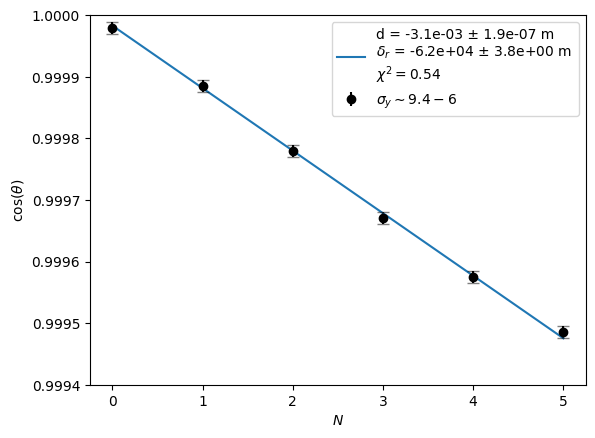

In [27]:
label = [ f"d = {sn(m.values['d'],1)} ± {sn(m.errors['d'],1)} m \n$\delta_r$ = {sn(m.values['a'],1)} ± {sn(m.errors['a'],1)} m \n$\chi^2 = {round(m.fval/m.ndof,2)}$", "$\sigma_y \sim 9.4-6$"]

m.visualize()
plt.ylim(0.9994,1.0)
plt.errorbar(N_fp1, cs_angolo, 9.43696979860459e-6, linestyle='None',fmt='.k',capsize=4, alpha=0.5)
plt.xlabel('$ N$')
plt.ylabel(r'cos($\theta$)')
plt.legend(label)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.savefig('fp1_data.pdf',bbox_inches='tight')

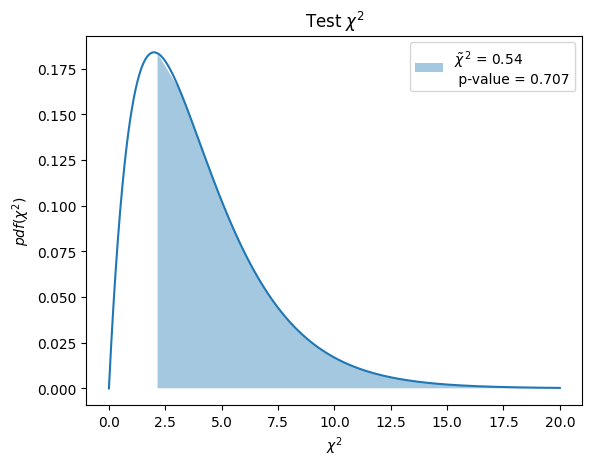

In [28]:
draw_p_value(m.fval,m.ndof,x_limit=20)
plt.savefig('fp1_pvalue.pdf')

In [29]:
fp11 = df['FP 1.1']
angolo = fp1['angolo'].to_numpy()
N_fp1 = fp1['N cerchio'].to_numpy()
cs_angolo = np.cos(angolo)

KeyError: 'FP 1.1'

In [ ]:
g = grafico(angolo,N_fp1,0.001,1,'Dati',save=True)
plt.close()

In [ ]:
l_laser = 633*1e-9
def f1(x,a,d):
  return (x*l_laser)/(2*d) + a*(l_laser/(4*np.pi*d))

In [ ]:
raggi = fp1['raggio cerchio']
dist = fp1['distanza da fuoco']

In [ ]:
formula = 'atan(dy/dx)'
err = formula_errori('dy,dx',formula,True)
Latex(r'$\sigma_\theta$ ='+err)

<IPython.core.display.Latex object>

In [ ]:
#@title errore angoli
def errore_angoli(dx,dy, errx=1e-1, erry=1e-1):
  formula = 'atan(dy/dx)'
  err = formula_errori('dy,dx',formula,False)

  err_ang = []

  dy=np.array(dy)
  if 1 == dy.size:
    values = {'dy':dy,
              'dx':dx
              }
    errors = {'dy':erry,
              'dx':errx
              }

    return valuta_errori(err, values, errors)

  for i,j in zip(dy,dx):

    values = {'dy':i,
              'dx':j
              }
    errors = {'dy':erry,
              'dx':errx
              }

    a = valuta_errori(err, values, errors)
    err_ang.append(a)
  return err_ang

In [ ]:
err_angoli_fp1 = errore_angoli(dist,raggi,errx=5,erry=1)
print(err_angoli_fp1)

[0.00583706827557932, 0.00584971685479495, 0.00586380303301451, 0.00587829550960368, 0.00589102679900632, 0.00590284411436101]


In [ ]:
formula = 'cos(theta)'
e = formula_errori('theta,', formula,True)
Latex(r'$\sigma_{cos(\theta)} = $ '+e)

<IPython.core.display.Latex object>

In [ ]:
err_angoli_fp1 = [np.sin(0.0017) for i in err_angoli_fp1]
print(err_angoli_fp1)

[0.001699999181166785, 0.001699999181166785, 0.001699999181166785, 0.001699999181166785, 0.001699999181166785, 0.001699999181166785]


In [ ]:
# Errore cos(angoli)
formula = 'cos(theta)'
expr = formula_errori('theta,', formula)

err_cs_angoli = []
for i,j in zip(angolo,err_angoli_fp1):

  val={'theta':i}
  err={'theta':j}

  a = valuta_errori(expr, val,err)
  err_cs_angoli.append(a)
  print(a)

1.09099217643385e-5
2.57846524453968e-5
3.56980606205279e-5
4.36262133386224e-5
4.95704874934774e-5
5.45226688645707e-5


In [ ]:
c = LeastSquares(N_fp1, cs_angolo, err_cs_angoli, f1)
m = Minuit(c, a=-61.91e3, d=-3.1185e-3)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1336 (χ²/ndof = 0.0)     │              Nfcn = 39               │
│ EDM = 1.23e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -61.909e3 │  0.009e3  │            │            │         │         │       │
│ 1 │ d    │-3.1186e-3 │ 0.0005e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────┐
│   │             a             d │
├───┼─────────────────────────────┤
│ a │          80.2 4.03237106e-6 │
│ d │ 4.03237106e-6      2.04e-13 │
└───┴─────────────────────────────┘

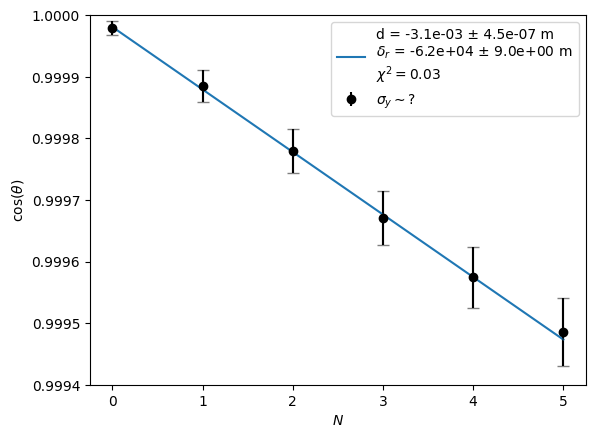

In [ ]:
label = [ f"d = {sn(m.values['d'],1)} ± {sn(m.errors['d'],1)} m \n$\delta_r$ = {sn(m.values['a'],1)} ± {sn(m.errors['a'],1)} m \n$\chi^2 = {round(m.fval/m.ndof,2)}$", "$\sigma_y \sim ?$"]

m.visualize()
plt.ylim(0.9994,1.0)
plt.errorbar(N_fp1, cs_angolo, err_cs_angoli, linestyle='None',fmt='.k',capsize=4, alpha=0.5)
plt.xlabel('$ N$')
plt.ylabel(r'cos($\theta$)')
plt.legend(label)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.savefig('fp1_data.pdf',bbox_inches='tight')

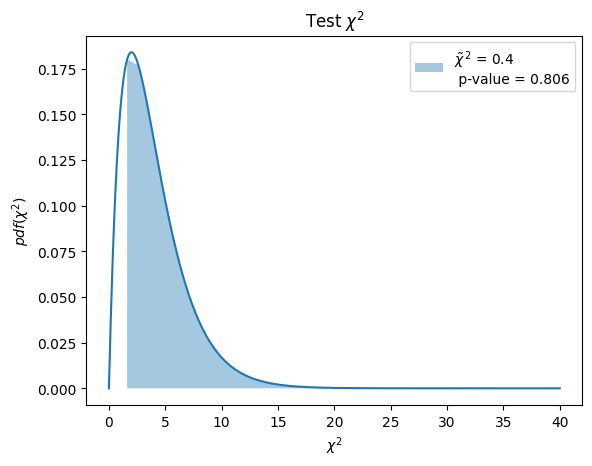

In [ ]:
draw_p_value(m.fval,m.ndof)
plt.savefig('fp1_pvalue.pdf')

# Fabry Perot 2

In [35]:
fp2 = df['FP 2']
N_fp2 = fp2['N'][6:]
d_micr_fp2 = fp2['d misurato'][6:]
d_acc = fp2['d accumulato'][6:]
scrt_d_fp2 = fp2['errore d'][6:]
# ang_fp2 = fp2['angolo']
print(fp2.keys())

Index(['parto da 1mm', 'd misurato', 'd accumulato', 'N', 'd', 'sigma d',
       'angolo', 'errore d', 'Unnamed: 8', 'raggio'],
      dtype='object')


In [ ]:
angolo_fp2 = np.arctan(2.4/171.4)
print('Angolo = ',angolo_fp2)

Angolo =  0.014001418705773967


In [ ]:
ang_err_fp2 = errore_angoli(171.4, 2.4, errx=0.01, erry=0.01)
print(ang_err_fp2)

5.83373384911562e-5


In [ ]:
Latex(r'$\theta$'+f' = {sn(angolo_fp2)} $\pm$ {sn(ang_err_fp2)}')

<IPython.core.display.Latex object>

In [ ]:
#@title Calcolo d
d_fp2 = []
for i in N_fp2:
  d_fp2.append(i*l_laser / (2*np.cos(angolo_fp2)))

print(d_fp2)

[1.4560427187760837e-05, 1.4876958213581724e-05, 1.4243896161939948e-05, 1.5826551291044388e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5826551291044388e-05, 1.55100202652235e-05, 1.5193489239402612e-05, 1.5193489239402612e-05, 1.5826551291044388e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5193489239402612e-05]


In [ ]:
#@title Errore d
formula = r'(n*l)/(2*cos(theta))'
expr = formula_errori('n,theta', formula, False)

d_err_fp2 = []

for i in N_fp2:

  values = {'n':i,  'theta':angolo_fp2, 'l':l_laser}
  errors = {'n':1,  'theta':ang_err_fp2}

  d_err_fp2.append(valuta_errori(expr, values, errors))

print(d_err_fp2)

[3.16531026044346e-7, 3.16531026054167e-7, 3.16531026034736e-7, 3.16531026084898e-7, 3.16531026064199e-7, 3.16531026054167e-7, 3.16531026074443e-7, 3.16531026064199e-7, 3.16531026054167e-7, 3.16531026064199e-7, 3.16531026054167e-7, 3.16531026074443e-7, 3.16531026084898e-7, 3.16531026074443e-7, 3.16531026064199e-7, 3.16531026064199e-7, 3.16531026084898e-7, 3.16531026054167e-7, 3.16531026074443e-7, 3.16531026064199e-7]


In [ ]:
#@title Media pesata d
d, err_d = media_pesata(d_fp2, d_err_fp2)
Latex(f'd = {d}  \pm { err_d}')

<IPython.core.display.Latex object>

In [ ]:
formula = 'd1/d2'
expr = formula_errori('d1,d2', formula)

values = {'d1':d, 'd2':15e-6}
errors = {'d1':err_d, 'd2':1e-7}

delta_d_err = valuta_errori(expr, values, errors)
print(delta_d_err)

0.00823791885543962


In [ ]:
delta_d = d/15e-6
Latex(f'd1/d2 = {delta_d} $\pm$ {delta_d_err}')

<IPython.core.display.Latex object>

In [63]:
scrt_d_fp2 = np.absolute(scrt_d_fp2)

In [66]:
a,b,c = [],[],[]
d_acc = np.array(d_acc)
scrt_d_fp2 = np.array(scrt_d_fp2)
for i in range(1,len(d_acc)-1):
    a.append(np.max([scrt_d_fp2[i],scrt_d_fp2[i-1],scrt_d_fp2[i+1]]))
    b.append(d_acc[i])
    c.append(0)

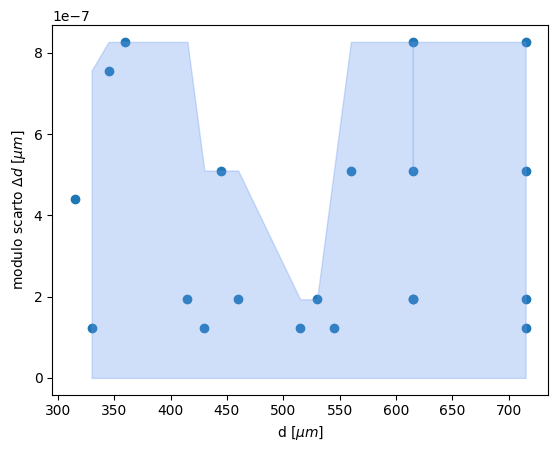

In [78]:
plt.scatter(d_acc,scrt_d_fp2)
plt.xlabel('d [$\mu m$]')
plt.ylabel('modulo scarto $\Delta d$ [$\mu m$]')
plt.fill_between(b,a,c,color='cornflowerblue', alpha=0.3)
plt.savefig('Scarto_delta_d_fp2.pdf',bbox_inches='tight')

# Michelson 1

In [ ]:
m1 = df['M 1']
dx = m1['dx [cm]']
dy = m1['dy [cm]']
N_m1 = m1['N']

In [ ]:
ang_m1 = []

for i,j in zip(dx,dy):
  ang_m1.append(np.arctan2(j,i))
print(ang_m1)

[0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653]


In [ ]:
err_ang_m1 = errore_angoli(dx,dy,errx=0.1, erry=0.1)
print(err_ang_m1)

[0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000564536115418465, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831, 0.000568385806498831]


In [ ]:
cs_ang_m1 = np.cos(ang_m1)

formula = 'cos(theta)'
expr = formula_errori('theta,', formula)
err_cs_ang_m1 = []

for i,j in zip(ang_m1, err_ang_m1):

  values = {'theta':i}
  errors = {'theta':j}

  err_cs_ang_m1.append(valuta_errori(expr,values, errors))

In [ ]:
# calcolo d
d_m1 = []
for i,j in zip(N_m1,ang_m1):
  d_m1.append(i*l_laser / (2*np.cos(j)))
  

# Errore d
formula = r'(n*l)/(2*cos(theta))'
expr = formula_errori('n,theta', formula, False)

d_err_m1 = []

for i,j,k in zip(N_fp2,ang_m1,err_ang_m1):

  values = {'n':i,  'theta':j, 'l':l_laser}
  errors = {'n':1,  'theta':k}

  d_err_m1.append(valuta_errori(expr, values, errors))

for i,j in zip(d_m1,d_err_m1):
  print('d = ',i,'±',j)

d =  1.4878573014428188e-05 ± 3.16565427391983e-7
d =  1.4562007631142482e-05 ± 3.16565429330491e-7
d =  1.4245442247856774e-05 ± 3.16565425495163e-7
d =  1.5195138397713894e-05 ± 3.16565435396146e-7
d =  1.5195138397713894e-05 ± 3.16565431310688e-7
d =  1.5511703780999598e-05 ± 3.16565429330491e-7
d =  1.5195138397713894e-05 ± 3.16565433332573e-7
d =  1.3928876864571068e-05 ± 3.16565431310688e-7
d =  1.4878573014428188e-05 ± 3.16565429330491e-7
d =  1.5511703780999598e-05 ± 3.16565431310688e-7
d =  1.4562007631142482e-05 ± 3.16565429330491e-7
d =  1.5195138397713894e-05 ± 3.16565433332573e-7
d =  1.4878615081608797e-05 ± 3.16566331879010e-7
d =  1.4562048803276696e-05 ± 3.16566329758553e-7
d =  1.5195181359940897e-05 ± 3.16566327680933e-7
d =  1.4878615081608797e-05 ± 3.16566327680933e-7
d =  1.5511747638272998e-05 ± 3.16566331879010e-7
d =  1.4562048803276696e-05 ± 3.16566325646150e-7
d =  1.5511747638272998e-05 ± 3.16566329758553e-7
d =  1.4562048803276696e-05 ± 3.16566327680933e-7


In [ ]:
d_m1_pes, d_m1_pes_err = media_pesata(d_m1,d_err_m1)
print(d_m1_pes,d_m1_pes_err)

1.49260746633188e-5 7.078626255838835e-08


In [ ]:
formula = 'd1/d2'
expr = formula_errori('d1,d2',formula)

values = {'d1':d_m1_pes,'d2':15e-6}
errors = {'d1':d_m1_pes_err,'d2':0.}


errore_calibro = valuta_errori(expr,values,errors)

In [ ]:
print(d_m1_pes/15e-6, errore_calibro)

0.995071644221255 0.00471908417055922


# Michelson 2: Pressione

In [ ]:
m2 = df['M 2']
p = m2['P']
n_m2 = m2['N']

<Axes: xlabel='x', ylabel='y'>

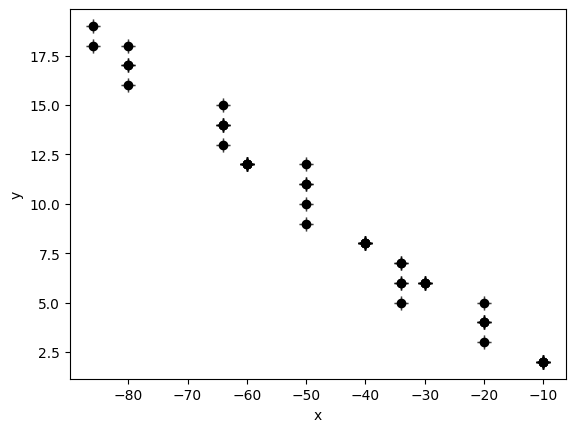

In [ ]:
grafico(p,n_m2,0,0,'dati')

In [ ]:
p_amb = 101 #kPascal
p = np.abs(p)

In [ ]:
d = 3.35
def pressione(dp,m):
  return 2*d*m*dp / l_laser

In [ ]:
c = LeastSquares(p, n_m2, 1, pressione)
m = Minuit(c, m=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.12 (χ²/ndof = 0.5)      │              Nfcn = 20               │
│ EDM = 2.37e-24 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │ 19.72e-9  │  0.28e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        m │
├───┼──────────┤
│ m │ 8.02e-20 │
└───┴──────────┘

In [ ]:
print(m.values['m']*101e3 + 1)

1.0019921263303802


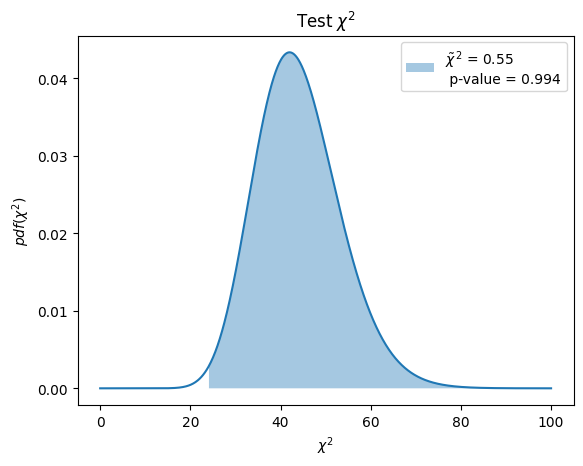

In [ ]:
draw_p_value(m.fval,m.ndof, x_limit=100)

# Michelson 4

In [ ]:
m4 = df['M 4']
ang_m4 = m4['angoli radianti']
N_m4 = m4['N']

In [ ]:
def n(t,N):
  d = 5.35*1e-3
  return (2*d - N*l_laser)*(1 - np.cos(t)) / (2*d*(1- np.cos(t))- N*l_laser)

In [ ]:
n_vetro = []
for i,j in zip(ang_m4,N_m4):
  n_vetro.append(n(i,j))
print(n_vetro)

[1.5537322443843748, 1.8574526011661765, 1.758500305533297, 1.7854387365292619, 1.7854387365292619, 1.8576422136563597, 1.7550562524542042, 1.8093424964989777, 1.8093424964989777, 1.6754894638478464, 1.5265957728829693, 1.6083224751348342, 1.6231822873395039, 1.65301562931094, 1.6231822873395039, 1.772770562223423, 1.703044950994163, 1.7365023370602035, 1.739794991635314, 1.8155830142664882, 1.8155830142664882]


1.7269053747405982
0.09482392867078411


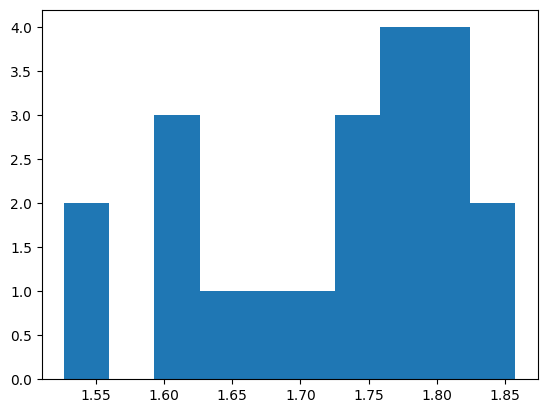

In [ ]:
plt.hist(n_vetro)
print(np.mean(n_vetro))
print(np.std(n_vetro))